In [ ]:
!pip install torchtext==0.17 torch datasets

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

![](https://www.tensorflow.org/static/text/tutorials/images/bidirectional.png)

In [2]:
!git clone https://github.com/MiuLab/SlotGated-SLU.git

Cloning into 'SlotGated-SLU'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 51 (delta 4), reused 2 (delta 2), pack-reused 44 (from 1)
Receiving objects: 100% (51/51), 426.21 KiB | 14.70 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [3]:
import sys

In [4]:
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
from nltk import word_tokenize

In [5]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
seed = 0

torch.manual_seed(seed)

In [7]:
import os

def read_dataset(path):
    with open(os.path.join(path, 'seq.in')) as f_words, \
        open(os.path.join(path, 'seq.out')) as f_tags, \
        open(os.path.join(path, 'label')) as f_intents:

        texts, slot_labels, intent_labels = [], [], []
        for words, tags, intent in zip(f_words, f_tags, f_intents):
            texts.append(words.strip().split())
            slot_labels.append(tags.strip().split())
            intent_labels.append(intent.strip())
        return Dataset.from_dict({"words": texts,
                                  "tags": slot_labels,
                                  "intent": intent_labels})

In [8]:
datasets = DatasetDict()
for split_name in ["train", "valid", "test"]:
    datasets[split_name] = read_dataset(f"/content/SlotGated-SLU/data/snips/{split_name}")

In [9]:
datasets["train"][0]

{'words': ['listen',
  'to',
  'westbam',
  'alumb',
  'allergic',
  'on',
  'google',
  'music'],
 'tags': ['O', 'O', 'B-artist', 'O', 'B-album', 'O', 'B-service', 'I-service'],
 'intent': 'PlayMusic'}

In [10]:
intent_to_example = {example["intent"]: example for example in datasets["train"]}
for example in intent_to_example.values():
    print('Intent:\t', example["intent"])
    print('Words:\t', '\t'.join(example["words"]))
    print('Tags:\t', '\t'.join(example["tags"]))
    print()

Intent:	 PlayMusic
Words:	 play	funky	heavy	bluesy
Tags:	 O	B-playlist	I-playlist	I-playlist

Intent:	 AddToPlaylist
Words:	 add	gabrial	mcnair	to	my	love	in	paris	list
Tags:	 O	B-artist	I-artist	O	B-playlist_owner	B-playlist	I-playlist	I-playlist	O

Intent:	 RateBook
Words:	 rate	richard	carvel	4	out	of	6
Tags:	 O	B-object_name	I-object_name	B-rating_value	O	O	B-best_rating

Intent:	 SearchScreeningEvent
Words:	 can	i	get	the	movie	schedule	for	loews	cineplex	entertainment
Tags:	 O	O	O	O	B-object_type	I-object_type	O	B-location_name	I-location_name	I-location_name

Intent:	 BookRestaurant
Words:	 i	want	to	eat	choucroute	at	a	brasserie	for	8
Tags:	 O	O	O	O	B-served_dish	O	O	B-restaurant_type	O	B-party_size_number

Intent:	 GetWeather
Words:	 tell	me	when	it	ll	be	chillier	in	cavalero	corner	id
Tags:	 O	O	O	O	O	O	B-condition_temperature	O	B-city	I-city	B-state

Intent:	 SearchCreativeWork
Words:	 go	to	the	photograph	the	inflated	tear
Tags:	 O	O	O	B-object_type	B-object_name	I-object_n

In [11]:
TEXT_LOWER = True

In [12]:
min_freq = 3
special_tokens = ['<unk>', '<pad>']

tokens_vocab = torchtext.vocab.build_vocab_from_iterator(datasets['train']['words'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

In [13]:
idx_to_label = list(set(datasets['train']['intent']))
label_to_idx = {label: idx for idx, label in enumerate(idx_to_label)}

In [14]:
idx_to_label

['GetWeather',
 'RateBook',
 'BookRestaurant',
 'SearchScreeningEvent',
 'PlayMusic',
 'AddToPlaylist',
 'SearchCreativeWork']

In [15]:
label_to_idx

{'GetWeather': 0,
 'RateBook': 1,
 'BookRestaurant': 2,
 'SearchScreeningEvent': 3,
 'PlayMusic': 4,
 'AddToPlaylist': 5,
 'SearchCreativeWork': 6}

In [16]:
unk_index = tokens_vocab['<unk>']
pad_index = tokens_vocab['<pad>']

In [17]:
unk_index, pad_index

(0, 1)

In [18]:
tokens_vocab["music"]

36

In [19]:
# tokens_vocab["musierkjferkjberkc"]

In [20]:
tokens_vocab.set_default_index(unk_index)

In [21]:
tokens_vocab["musierkjferkjberkc"]

0

In [22]:
tokens_vocab.lookup_indices(["music"])

[36]

In [23]:
tokens_vocab.lookup_token(36)

'music'

In [24]:
words = word_tokenize("book canteen at 16 o clock")
words

['book', 'canteen', 'at', '16', 'o', 'clock']

In [25]:
idx_example = tokens_vocab.forward(words)
idx_example

[12, 0, 9, 501, 179, 184]

In [26]:
tokens_vocab.lookup_tokens(idx_example)

['book', '<unk>', 'at', '16', 'o', 'clock']

In [27]:
def numericalize_data(example, tokens_vocab, label_to_idx):
#     print(example)
    token_idxs = tokens_vocab.forward(example['words'])
    label_idx = label_to_idx[example['intent']]
    return {'words': token_idxs, 'intent': label_idx}

In [28]:
transformed_data = datasets.map(numericalize_data, fn_kwargs={'tokens_vocab': tokens_vocab,
                                                          'label_to_idx': label_to_idx},
                                remove_columns=["tags"])

Map:   0%|          | 0/13084 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [29]:
transformed_data["train"][0]

{'words': [187, 5, 0, 0, 0, 19, 201, 36], 'intent': 4}

In [30]:
transformed_data = transformed_data.with_format(type='torch')

In [31]:
transformed_data['train'][0]

{'words': tensor([187,   5,   0,   0,   0,  19, 201,  36]),
 'intent': tensor(4)}

In [32]:
def collate_batch(batch):
    # print("Original batch:")
    # print(batch)
    batch_tokens = [example['words'] for example in batch]
    batch_labels = torch.stack([example['intent'] for example in batch])
    batch_tokens = nn.utils.rnn.pad_sequence(batch_tokens, padding_value=tokens_vocab['<pad>'], batch_first=True)
    batch = {'words': batch_tokens,
             'intent': batch_labels}
    # print("New batch:")
    # print(batch)
    return batch

In [33]:
BATCH_SIZE = 8

train_dataloader = torch.utils.data.DataLoader(transformed_data['train'],
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_batch,
                                               shuffle=True)

validation_dataloader = torch.utils.data.DataLoader(transformed_data['valid'],
                                                    batch_size=BATCH_SIZE,
                                                    collate_fn=collate_batch)

test_dataloader = torch.utils.data.DataLoader(transformed_data['test'],
                                              batch_size=BATCH_SIZE,
                                              collate_fn=collate_batch)

In [34]:
for batch in train_dataloader:
    break

In [35]:
batch

{'words': tensor([[  15,    0, 2064,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1],
         [ 246,    6,   82,   47,    4,  485,   62,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1],
         [  33,   34,   28,  496,    4,    0,  412, 1358,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1],
         [  11,   34,   42,    5,   28,  223,    4, 1456,   25, 1523,    1,    1,
             1,    1,    1,    1,    1,    1],
         [  11,   91,  228, 1360,  495,    4,   68,  338,    4,    0,  429, 1371,
             1,    1,    1,    1,    1,    1],
         [   8,   30,   20,   71,    3,   77,   31,    7,   21,    1,    1,    1,
             1,    1,    1,    1,    1,    1],
         [ 181,    3,   45,    6,   52,    9,    3,  250,   32,  145,   49,   98,
          1510,    6,   20,  380,    4,  852],
         [  24,   20,  101,    3,   52,    1,    1,    1,    1,    1,    1,    1,
      

![](https://www.tensorflow.org/static/text/tutorials/images/bidirectional.png)

In [36]:
len(tokens_vocab)

2834

In [37]:
embedding_layer = nn.Embedding(len(tokens_vocab), 50, padding_idx=pad_index)

In [38]:
for parameter in embedding_layer.parameters():
    embeddings_matrix = parameter
    print(parameter.shape)

torch.Size([2834, 50])


In [39]:
embeddings_matrix[1] # <pad> embedding

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<SelectBackward0>)

In [40]:
embeddings_matrix[100]

tensor([ 0.1650,  0.0204,  1.2037,  0.2401, -0.1820, -0.2186, -0.5963, -0.5573,
        -0.5243, -0.3910, -2.0050, -0.5602, -0.2162,  1.1429, -1.1941, -0.4540,
        -1.0449,  0.7967,  0.8036,  0.4676,  0.1720,  0.7576, -1.1577,  0.4929,
        -1.7412,  0.7552, -0.0104,  0.4833,  0.0666, -0.8208,  0.3908, -0.6064,
        -1.1170,  1.0868,  0.4369, -0.1457,  0.7368,  1.4199, -0.4872, -0.5149,
        -1.7396,  0.3496,  1.4956,  0.4697, -0.1690,  0.8187,  0.1733,  1.8932,
         1.1973,  0.0214], grad_fn=<SelectBackward0>)

In [41]:
embeddings_matrix[150]

tensor([ 0.2214, -1.3330,  0.3819, -1.5220,  0.5055,  1.2236,  0.4525, -0.5733,
        -1.7215, -0.2373, -0.2025,  0.4404, -0.3318,  0.8093, -1.0093,  1.1528,
        -0.2871, -0.8127,  0.4055,  0.6531,  0.9512, -1.6428, -0.4955, -0.6698,
        -1.1607,  0.0861,  0.9691,  0.1373, -1.1436,  0.7346,  1.4399,  0.9323,
        -0.5145,  1.5709,  1.1021, -0.7499, -1.3485,  0.0300, -0.7286,  0.5937,
        -1.2953,  0.9768, -0.4292, -0.7080, -1.7187,  0.0722,  2.0081,  0.3306,
        -0.4974, -2.3718], grad_fn=<SelectBackward0>)

In [42]:
batch["words"].shape # (batch_size, max_len_batch)

torch.Size([8, 18])

In [43]:
emb_batch = embedding_layer(batch["words"])

In [44]:
emb_batch.shape # (batch_size, max_len_batch, emb_dim)

torch.Size([8, 18, 50])

In [100]:
embedding_dim=50
hidden_dim=25
n_layers=1
bidirectional=False
lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional, dropout=0, batch_first=True)

In [101]:
output, (hidden, cell) = lstm(emb_batch)

In [102]:
output.shape # полезный выход для каждого слова, можно использовать в задачах
# batch_size x max_len x hidden_dim

torch.Size([8, 18, 25])

In [103]:
hidden.shape # выход для последнего слова, типа векторное представление всего предложения
# 1 x batch_size x hidden_dim

torch.Size([1, 8, 25])

In [104]:
hidden[0][0]

tensor([-1.1245e-04,  1.9062e-04, -1.3555e-04,  1.9626e-04,  3.8035e-04,
         1.5671e-04, -2.0670e-04, -5.8348e-05,  2.3163e-04,  1.6093e-04,
        -9.8339e-05, -1.3441e-05,  9.4474e-05,  4.6222e-05, -5.2591e-05,
        -8.3183e-05,  6.8734e-05,  5.0102e-05, -1.9819e-04, -8.8560e-05,
         4.0308e-05,  2.1371e-04, -5.5684e-05, -6.5188e-05,  7.6373e-06],
       grad_fn=<SelectBackward0>)

In [105]:
output[0][-1]

tensor([-1.1245e-04,  1.9062e-04, -1.3555e-04,  1.9626e-04,  3.8035e-04,
         1.5671e-04, -2.0670e-04, -5.8348e-05,  2.3163e-04,  1.6093e-04,
        -9.8339e-05, -1.3441e-05,  9.4474e-05,  4.6222e-05, -5.2591e-05,
        -8.3183e-05,  6.8734e-05,  5.0102e-05, -1.9819e-04, -8.8560e-05,
         4.0308e-05,  2.1371e-04, -5.5684e-05, -6.5188e-05,  7.6373e-06],
       grad_fn=<SelectBackward0>)

In [106]:
cell.shape # "бесполезный" для нас контекст, которым обменивается LSTM

torch.Size([1, 8, 25])

In [113]:
X = torch.arange(20, dtype=torch.float).reshape(4, 5)
X

tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.],
        [15., 16., 17., 18., 19.]])

In [116]:
dropout = nn.Dropout(0.50)

In [117]:
dropout(X)

tensor([[ 0.,  0.,  4.,  0.,  8.],
        [ 0., 12., 14.,  0.,  0.],
        [20., 22., 24., 26., 28.],
        [30., 32.,  0., 36., 38.]])

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

In [118]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        output, (hidden, cell) = self.lstm(embedded) # hidden -- вектор после обработки последнего слова предложения
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [119]:
vocab_size = len(tokens_vocab)
embedding_dim = 100
hidden_dim = 100
output_dim = len(idx_to_label)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate,
             pad_index)

In [120]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 688,007 trainable parameters


In [123]:
688007 * 32 / 8 / 1024 / 1024

2.6245384216308594

In [124]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [125]:
criterion = nn.CrossEntropyLoss() # loss function, функция ошибки

In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [127]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['words'].to(device)
        label = batch['intent'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        optimizer.zero_grad()

    return epoch_losses, epoch_accs

In [128]:
def evaluate(dataloader, model, criterion, device):

    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['words'].to(device)
            label = batch['intent'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [129]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [130]:
model = model.to(device)
criterion = criterion.to(device)

In [131]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(validation_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'lstm.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 88/88 [00:00<00:00, 427.37it/s]
epoch: 1
train_loss: 0.433, train_acc: 0.866
valid_loss: 0.120, valid_acc: 0.959
evaluating...: 100%|██████████| 88/88 [00:00<00:00, 569.10it/s]
epoch: 2
train_loss: 0.152, train_acc: 0.953
valid_loss: 0.086, valid_acc: 0.974
evaluating...: 100%|██████████| 88/88 [00:00<00:00, 600.18it/s]
epoch: 3
train_loss: 0.124, train_acc: 0.963
valid_loss: 0.069, valid_acc: 0.983
evaluating...: 100%|██████████| 88/88 [00:00<00:00, 574.10it/s]
epoch: 4
train_loss: 0.090, train_acc: 0.972
valid_loss: 0.077, valid_acc: 0.977
evaluating...: 100%|██████████| 88/88 [00:00<00:00, 617.37it/s]
epoch: 5
train_loss: 0.080, train_acc: 0.975
valid_loss: 0.061, valid_acc: 0.984
evaluating...: 100%|██████████| 88/88 [00:00<00:00, 626.70it/s]
epoch: 6
train_loss: 0.072, train_acc: 0.977
valid_loss: 0.065, valid_acc: 0.983
evaluating...: 100%|██████████| 88/88 [00:00<00:00, 623.53it/s]
epoch: 7
train_loss: 0.061, train_acc: 0.981
valid_loss: 0.072, va

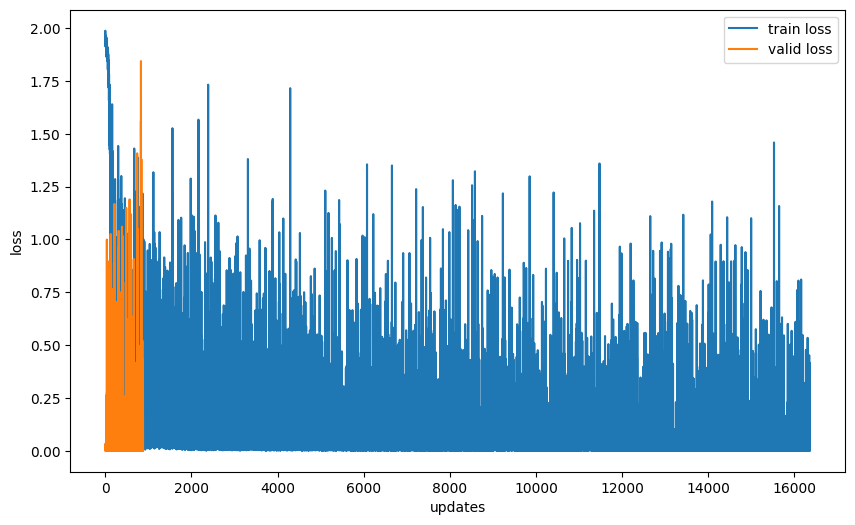

In [132]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

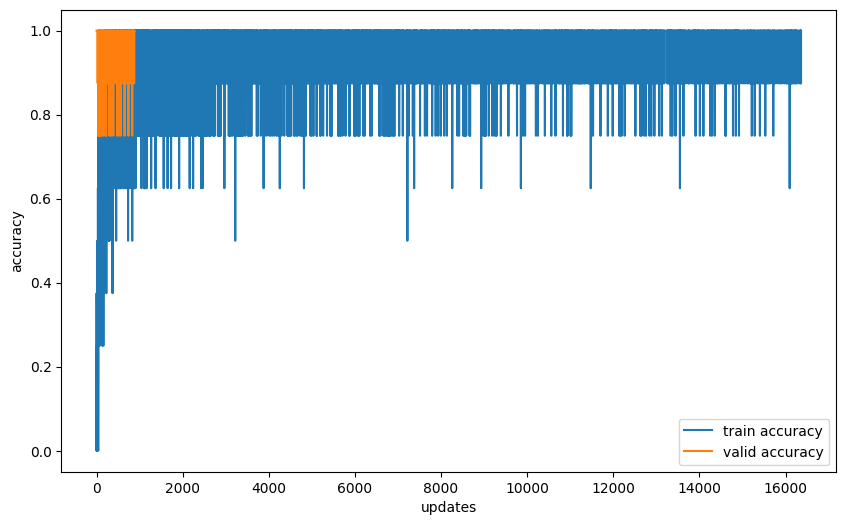

In [133]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [134]:
model.load_state_dict(torch.load('lstm.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 88/88 [00:00<00:00, 503.97it/s]
test_loss: 0.077, test_acc: 0.970


In [136]:
text = 'book canteen at 16 o clock'

words = word_tokenize(text, language='russian')
words

['book', 'canteen', 'at', '16', 'o', 'clock']

In [138]:
ids = tokens_vocab.forward(words)
ids

[12, 0, 9, 501, 179, 184]

In [139]:
tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
tensor

tensor([[ 12,   0,   9, 501, 179, 184]], device='cuda:0')

In [140]:
prediction = model(tensor).squeeze(dim=0)
print(prediction)

tensor([-0.1965, -1.9097,  8.0413,  0.0791, -2.2432, -2.4152, -1.3948],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


In [141]:
probability = torch.softmax(prediction, dim=-1)
probability

tensor([2.6426e-04, 4.7639e-05, 9.9920e-01, 3.4811e-04, 3.4130e-05, 2.8736e-05,
        7.9724e-05], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [142]:
predicted_idx = prediction.argmax(dim=-1).item()
predicted_idx

2

In [143]:
idx_to_label[predicted_idx]

'BookRestaurant'

In [144]:
def process_line(text, model, tokens_vocab, idx_to_label, device, lower=True):
    tokens = word_tokenize(text, language='russian')
    ids = tokens_vocab.forward(tokens)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_idx = prediction.argmax(dim=-1).item()
    predicted_class = idx_to_label[predicted_idx]
    predicted_probability = probability[predicted_idx].item()
    return predicted_class, predicted_probability

In [145]:
text = 'book canteen at 16 o clock'

process_line(text, model, tokens_vocab, idx_to_label, device, TEXT_LOWER)

('BookRestaurant', 0.9991974234580994)

In [146]:
text = 'I want to listen something nice'

process_line(text, model, tokens_vocab, idx_to_label, device, TEXT_LOWER)

('PlayMusic', 0.9444144368171692)

In [147]:
text = 'How cold it will be tomorrow?'

process_line(text, model, tokens_vocab, idx_to_label, device, TEXT_LOWER)

('GetWeather', 0.9996844530105591)

![](https://karpathy.github.io/assets/rnn/diags.jpeg)